# Исследование объявлений о продаже квартир

Используя данные о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет, нужно определить рыночную стоимость объектов недвижимости. Кроме того, необходимо отследить возможные аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### 1. Изучение исходных данных. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data_apartament = pd.read_csv("/datasets/real_estate_data.csv",sep='\t')
data_apartament.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [38]:
display(data_apartament.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,center_km,price_metr,week_day_exposition,year_day_exposition,month_day_exposition,floor_category,part_living_area,part_kitchen_area
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,True,...,755.0,NaN,16.0,120370.370370,3,2019,3,другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,True,...,NaN,81.0,18.0,82920.792079,1,2018,12,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,True,...,574.0,558.0,13.0,92785.714286,3,2015,8,другой,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,True,...,234.0,424.0,6.0,408176.100629,4,2015,7,другой,NaN,NaN
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,True,...,48.0,121.0,8.0,100000.000000,1,2018,6,другой,0.320000,0.410000


Изучим пропуски данных более подробно. Рассмотрим строки, в которых отсутствует информация о парках в радиусе 3км:

In [3]:
print(data_apartament[data_apartament["parks_around3000"].isna()].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5518 entries, 5 to 23698
Data columns (total 22 columns):
total_images            5518 non-null int64
last_price              5518 non-null float64
total_area              5518 non-null float64
first_day_exposition    5518 non-null object
rooms                   5518 non-null int64
ceiling_height          2943 non-null float64
floors_total            5508 non-null float64
living_area             4895 non-null float64
floor                   5518 non-null int64
is_apartment            628 non-null object
studio                  5518 non-null bool
open_plan               5518 non-null bool
kitchen_area            4803 non-null float64
balcony                 2808 non-null float64
locality_name           5510 non-null object
airports_nearest        0 non-null float64
cityCenters_nearest     0 non-null float64
parks_around3000        0 non-null float64
parks_nearest           0 non-null float64
ponds_around3000        0 non-null float64
pon

Как видим, в столбцах *airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000 и ponds_nearest* также отсутствуют значения. Это говорит о том, что данные во всех этих стобцах отсутствуют одновременно. Возможно, для этих объявлений система не смогла определить адрес объектов недвижимости чтобы заполнить данные значения.

Обратим внимание, что количество пропусков в столбце *parks_nearest* больше, чем в *parks_around3000*. Изучим более подробно эту ситуацию:

In [4]:
print("Пропусков в parks_around3000:", data_apartament[data_apartament["parks_around3000"].notna()]["total_images"].count())
print("Пропусков в parks_nearest:", data_apartament[data_apartament["parks_nearest"].notna()]["total_images"].count())
tmp = data_apartament[data_apartament["parks_around3000"].notna() & data_apartament["parks_nearest"].isna()]
print(tmp["parks_around3000"].value_counts())


Пропусков в parks_around3000: 18181
Пропусков в parks_nearest: 8079
0.0    10102
Name: parks_around3000, dtype: int64


Как видим, все пропуски в столбце *parks_nearest* приходятся на пустые или нулевые значения *parks_around3000*, что означает, что в *parks_nearest* отсутствует информация только объектов, где не удалось определить наличие парков рядом либо определили, что парков рядом нет. Это вполне логичные пропуски и заполнять их не стоит - в этом случае действительно невозможно указать арсстояние до ближайшего парка.

Полностью аналогичная ситуация наблюдается и с прудами:

In [5]:
print("Пропусков в ponds_around3000:", data_apartament[data_apartament["ponds_around3000"].notna()]["total_images"].count())
print("Пропусков в ponds_nearest:", data_apartament[data_apartament["ponds_nearest"].notna()]["total_images"].count())
tmp = data_apartament[data_apartament["ponds_around3000"].notna() & data_apartament["ponds_nearest"].isna()]
print(tmp["ponds_around3000"].value_counts())

Пропусков в ponds_around3000: 18181
Пропусков в ponds_nearest: 9110
0.0    9071
Name: ponds_around3000, dtype: int64


### Вывод

### Общая информация
Из общей информации по файлу видно, что перед нами таблица из 23699 записей, состоящая из 22 именованных столбцов. Во многих есть несоответствие типов и данные не полные.
### Перечень выявленных аномалий
**Необходимо заполнить пропуски в столбцах:**
1. ceiling_height(высота потолков) - Достоверно восстановить недостающие значения не получится, а заполнять их различными средними не стоит, т.к. это вызовет изменение статистики. Лучше вообще не учитывать эти строки при анализе зависимости цены от данного параметра.
2. is_apartment(принадлежность к квартиры к виду апартаменты) - Очень похоже, что если данный признак не заполнен, то квартира не является аппартаментами, значит можно все пропуски заполнить значением False.
3. balcony(количество балконов) - заполняем нулями, т.к. если количество балконов не заполнено, значит их нет.
4. living_area(жилая площадь) - Достоверно восстановить недостающие значения не получится, а заполнять их различными средними не стоит, т.к. это вызовет изменение статистики. Лучше вообще не учитывать эти строки при анализе зависимости цены от данного параметра.
5. kitchen_area(площадь кухни) - Достоверно восстановить недостающие значения не получится, а заполнять их различными средними не стоит, т.к. это вызовет изменение статистики. Лучше вообще не учитывать эти строки при анализе зависимости цены от данного параметра.
6. floors_total(этажность дома) - отсутствует в небольшом количестве данных (0.3%), восстановить невозможно. Предлагается эти данные удалить.
7. airports_nearest(удаленность до ближайшего аэропорта) и ряд других характеристик об окружающей инфраструктуре - отсутствует в 23.2% данных. Заполнить их невозможно, поэтому их просто не нужно учитывать в анализе.
8. locality_name(название населенного пункта) - необходимо привести к нижнему регистру
9. days_exposition - пропуски можно не заполнять. Просто не будем учитывать эти данные при анализе.
 
 **Несоответствия типов в столбцах:**
 "balcony", "days_exposition", "floors_total", "ponds_around3000", "parks_around3000"
 
 **Необходимо отформатировать "first_day_exposition"**
  

### 2. Предобработка данных

In [6]:
#форматируем дату публикации
data_apartament["first_day_exposition"] = pd.to_datetime(data_apartament["first_day_exposition"],format="%Y-%m-%dT%H:%M:%S")

#заменим пропуски балконов на 0.0, т.к. если кол-во балконов не указано, можно предположить, что их нет.
data_apartament["balcony"] = data_apartament["balcony"].fillna(0.0)

Заменим типы данных.
*В процессе выполнения работы выяснилось, что функция to_numeric() не работает, если в столбце есть пустые значения, поэтому произведем замену с помощью функции*

In [7]:
#изменяем тип данных float на integer
data_apartament["balcony"] = pd.to_numeric(data_apartament["balcony"], downcast='integer',errors="ignore")

data_apartament["days_exposition"] = data_apartament["days_exposition"].apply(lambda x: int(x) if not pd.isna(x) else None)
data_apartament["floors_total"] = data_apartament["floors_total"].apply(lambda x: int(x) if not pd.isna(x) else None)
data_apartament["ponds_around3000"] = data_apartament["ponds_around3000"].apply(lambda x: int(x) if not pd.isna(x) else None)
data_apartament["parks_around3000"] = data_apartament["parks_around3000"].apply(lambda x: int(x) if not pd.isna(x) else None)

#уберем квартиры с неизвестным количеством этажей в доме
data_apartament = data_apartament[data_apartament['floors_total'].notna()]

#изменяем тип данных апартаменты на булевский
data_apartament["is_apartment"] = data_apartament["is_apartment"].astype("bool")

#проверим выполение изменений типа данных
data_apartament.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23613 non-null int64
last_price              23613 non-null float64
total_area              23613 non-null float64
first_day_exposition    23613 non-null datetime64[ns]
rooms                   23613 non-null int64
ceiling_height          14495 non-null float64
floors_total            23613 non-null float64
living_area             21743 non-null float64
floor                   23613 non-null int64
is_apartment            23613 non-null bool
studio                  23613 non-null bool
open_plan               23613 non-null bool
kitchen_area            21382 non-null float64
balcony                 23613 non-null int8
locality_name           23565 non-null object
airports_nearest        18081 non-null float64
cityCenters_nearest     18104 non-null float64
parks_around3000        18105 non-null float64
parks_nearest           8045 non-null float64
ponds_aroun

In [8]:
#проверим на наличие дубликатов в таблице
print("Количество дубликатов:",data_apartament.duplicated().sum())

#проверим гипотизу несоответствия количества комнат и типа жилья studio
hipotes_stuio = data_apartament.query("rooms > 1 and studio == True")
print("Количество несоответствий по студиям:",len(hipotes_stuio))

#убедимся в отсутствии необходимости по предобработке данных в названиях населенных пунктов
data_apartament["locality_name"] = data_apartament["locality_name"].str.lower()
print(data_apartament["locality_name"].value_counts())

Количество дубликатов: 0
Количество несоответствий по студиям: 0
санкт-петербург                       15651
посёлок мурино                          520
посёлок шушары                          439
всеволожск                              398
пушкин                                  369
                                      ...  
поселок коммунары                         1
коттеджный поселок кивеннапа север        1
деревня тихковицы                         1
деревня новолисино                        1
посёлок шугозеро                          1
Name: locality_name, Length: 364, dtype: int64


### 3. Расчет недостающих величин

In [9]:
#добавляем столбец с расстоянием квартиры от центра в километрах
centers_nearest_km = data_apartament["cityCenters_nearest"] / 1000
data_apartament["center_km"] = centers_nearest_km.apply(lambda x: int(x) if not pd.isna(x) else None)

#добавляем столбец с ценой квадратного метра квартиры 
try:
    data_apartament["price_metr"] = data_apartament["last_price"]/data_apartament["total_area"]
except:
    data_apartament["price_metr"] = 0
    
#добавляем столбец с днем недели, месяцем и годом публикации объявления
data_apartament["week_day_exposition"] = data_apartament["first_day_exposition"].dt.weekday
data_apartament["year_day_exposition"] = data_apartament["first_day_exposition"].dt.year
data_apartament["month_day_exposition"] =  data_apartament["first_day_exposition"].dt.month

#добавляем столбец с разбивкой по группам этажей
data_apartament["floor_category"] = "другой"
data_apartament["floor_category"] = data_apartament["floor_category"].where(data_apartament["floor"] != 1,"первый")
data_apartament["floor_category"] = (data_apartament["floor_category"]
                                    .where(data_apartament["floor"] !=data_apartament["floors_total"],"последний")
)

#добавляем столбец отношения жилой площади к общей площади
try:
    data_apartament["part_living_area"] = data_apartament["living_area"]/data_apartament["total_area"]
except:
    data_apartament["part_living_area"] = 0
    
#добавляем столбец отношения площади кухни к общей площади
try:
    data_apartament["part_kitchen_area"] = data_apartament["kitchen_area"]/data_apartament["total_area"]
except:
    data_apartament["part_kitchen_area"] = 0
#data_apartament = pd.set_option('display.max_columns',30)    
data_apartament.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,center_km,price_metr,week_day_exposition,year_day_exposition,month_day_exposition,floor_category,part_living_area,part_kitchen_area
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,True,...,755.0,NaN,16.0,120370.370370,3,2019,3,другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,True,...,NaN,81.0,18.0,82920.792079,1,2018,12,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,True,...,574.0,558.0,13.0,92785.714286,3,2015,8,другой,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,True,...,234.0,424.0,6.0,408176.100629,4,2015,7,другой,NaN,NaN
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,True,...,48.0,121.0,8.0,100000.000000,1,2018,6,другой,0.320000,0.410000


### 4. Исследовательский анализ данных:

----Площадь квартиры----


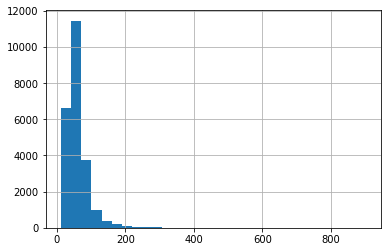

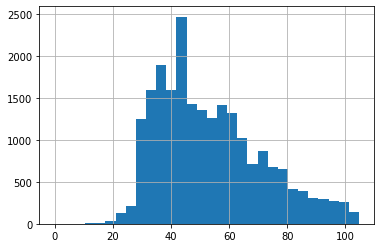

In [10]:
print("----Площадь квартиры----")
data_apartament["total_area"].hist(bins = 30)
plt.show()
data_apartament["total_area"].hist(bins = 30, range=(0, data_apartament['total_area'].quantile(0.75) * 1.5))
plt.show()

----Площадь кухни----


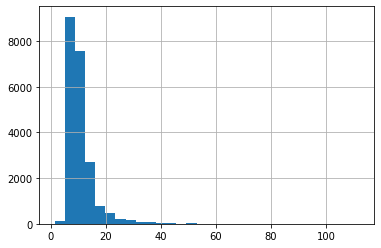

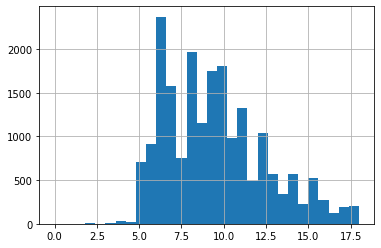

In [11]:
print("----Площадь кухни----")
data_apartament["kitchen_area"].hist(bins = 30)
plt.show()
data_apartament["kitchen_area"].hist(bins = 30, range=(0, data_apartament['kitchen_area'].quantile(0.75) * 1.5))
plt.show()

----Площадь жилая----


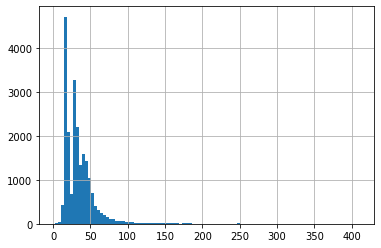

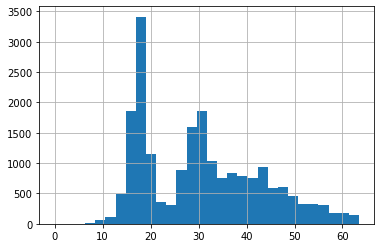

In [12]:
print("----Площадь жилая----")
data_apartament["living_area"].hist(bins = 100)
plt.show()
data_apartament["living_area"].hist(bins = 30, range=(0, data_apartament['living_area'].quantile(0.75) * 1.5))
plt.show()

----Цена----


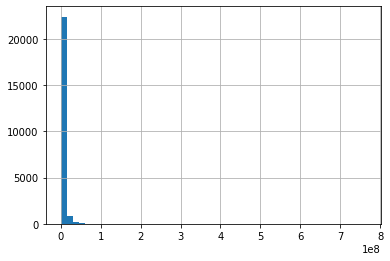

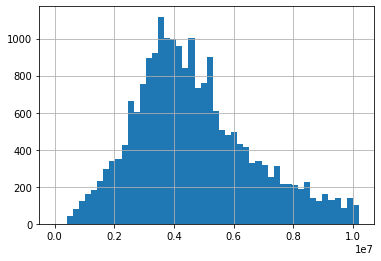

In [13]:
print("----Цена----")
data_apartament["last_price"].hist(bins = 50)
plt.show()
data_apartament["last_price"].hist(bins = 50, range=(0, data_apartament['last_price'].quantile(0.75) * 1.5))
plt.show()

----Стоимость квадратного метра----


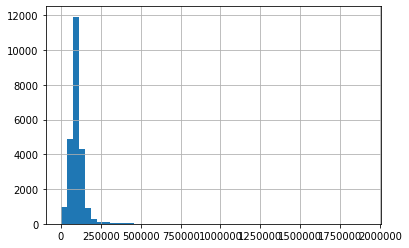

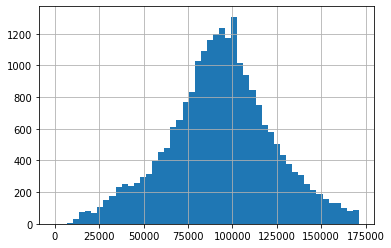

In [14]:
print("----Стоимость квадратного метра----")
data_apartament["price_metr"].hist(bins = 50)
plt.show()
data_apartament["price_metr"].hist(bins = 50, range=(0, data_apartament['price_metr'].quantile(0.75) * 1.5))
plt.show()

----Количество комнат----


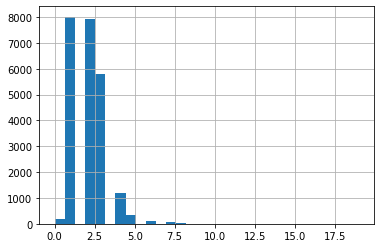

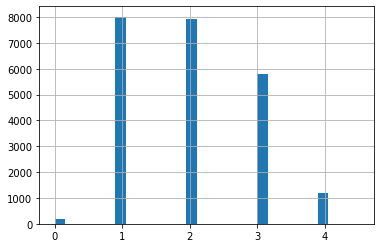

In [15]:
print("----Количество комнат----")
data_apartament["rooms"].hist(bins = 30)
plt.show()
data_apartament["rooms"].hist(bins = 30, range=(0, data_apartament['rooms'].quantile(0.75) * 1.5))
plt.show()

----Высота потолков----


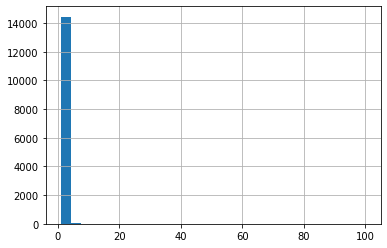

In [16]:
print("----Высота потолков----")
data_apartament["ceiling_height"].hist(bins = 30)
plt.show()

----Высота потолков от 2 до 5 м----


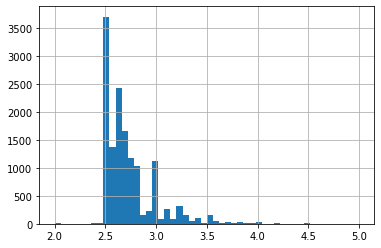

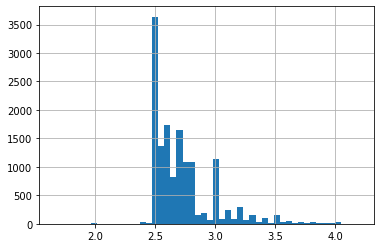

In [17]:
print("----Высота потолков от 2 до 5 м----")
data_apartament["ceiling_height"].hist(bins = 50, range=(2,5))
plt.show()
data_apartament["ceiling_height"].hist(bins = 50, range=(data_apartament['ceiling_height'].quantile(0.25) * 0.66, 
                                                         data_apartament['ceiling_height'].quantile(0.75) * 1.5))
plt.show()

----Количество дней было опубликовано объявление----


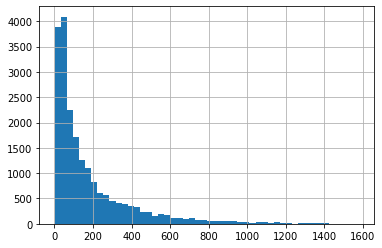

In [18]:
print("----Количество дней было опубликовано объявление----")
data_apartament["days_exposition"].hist(bins = 50)
plt.show()

----Количество дней было опубликовано объявление с ограничением максимального срока----


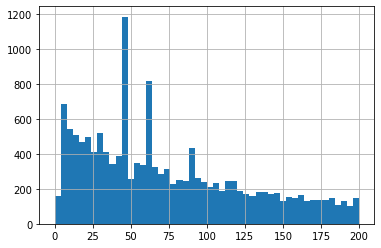

count    20441.000000
mean       180.884839
std        219.685543
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64


In [19]:
print("----Количество дней было опубликовано объявление с ограничением максимального срока----")
data_apartament["days_exposition"].hist(bins = 50,range=(0,200))
plt.show()
print(data_apartament["days_exposition"].describe())

-------Часть площади кухни от общей площади-------


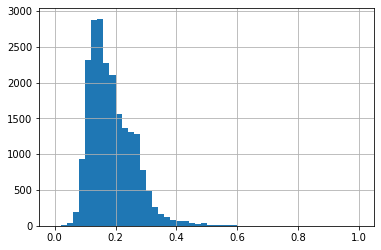

In [20]:
print("-------Часть площади кухни от общей площади-------")
data_apartament["part_kitchen_area"].hist(bins = 50,range=(0,1))
plt.show()

### Анализ гистограмм
По большинству характерных параметров квартир были построены гистограммы. Хорошо видно, что в каждом случае есть несколько квартир, которые сильно выделяются из общей массы. У них огромная высота потолка (до 100м, что, видимо, является ошибкой в данных), огромная площадь (до 900 кв.м.) и стоимость (до 800млн. руб). Все эти объекты недвижимости не стоит рассматривать в анализе, т.к. основной целью работы является определение типовых (разумных) цен на жилье в зависимости от его характеристик. Нет смысла анализировать квартиру площадью 900кв.м и запредельной стоимостью, т.к. она не является среднестатистическим жильем. Таких квартир единицы и нет смысла говорить про какую-то статистику по этим квартирам - каждая из них уникальна со своей ценой. Поэтому есть смысл удалить из рассмотрения все квартиры, показатели которых выходят за рамки правого "уса" из "диаграммы усов". 

Построение гистограмм с параметрами, ограниченными "усами", доказывает, что в этом случае мы можем говорить о некоторой статистике - гистограммы выглядят вполне информативно и полно.

На гистограмме жилой площади отчетливо виден пик около 45кв.м - очевидно, это типовые 1-комнатные квартиры.

Типовые площади кухни - 6, 8 и 9-10 метров, что тоже вполне соотносится с типовыми значениями.

На гистограмме жилой площади два отчетливых пика - 19кв.м. для "однушек" и около 30 для "двушек". Жилая площадь "трешек", котороых тоже много, не так явно выражена - она распределена в районе 45кв.м.

Гистограмма стоимости квартиры соответствует нормальному закону распределения с центром в 4 млн. руб. Стоимость квадратного метра также подчиняется нормальному закону распределения с центром в 95 тыс. руб. за 1 метр.

На рынке недвижимости пребладают квартиры с 1, 2 и чуть реже с 3 комнатами. Доля остальных квартир значительно ниже.

Отдельно стоит обратить внимание на гистограмму длительности продажи квартиры. Там явно присутствуют пики в 45 и 60 дней. Возможное объяснение этого феномена может заключаться в том, что люди забывают снять с продажи объявление и оно автоматически закрывается через 45 или 60 дней. В целом же, если не считать эти выбросы, чаще всего квартиры продаются в первый месяц после подачи объявления.

**Следствие:** для корректного анализа квартир необходимо прочистить данные, удалив из рассмотрения все редкие и не типичные объекты недвижимости. В качестве критерия "нетипичности" предлагается взять границы усов из диаграммы "ящик с усами". 

Далее проведем анализ корректности жилых площадей и кухонь. Для этого проверим, есть ли у нас квартиры, в которых кухня занимает более половины площади - даже если такие квартиры реально существуют, они не являются типовыми и их не следует рассматривать в статистическом анализе). Кроме того, убедимся, что в студиях и аппаратаментах кухни нет.

In [21]:
(print("Доля неправдоподобных кухонь - студий или апартаментов:",data_apartament
                                    .query("part_kitchen_area>=0.5 and (studio==True or is_apartment==True)")
                                          ["part_kitchen_area"]
                                    .count()/len(data_apartament["part_kitchen_area"])) 
)


Доля неправдоподобных кухонь - студий или апартаментов: 0.002540973192732817


Такие странные объекты существуют, но их довольно мало - 0.2%. Их стоит удалить из рассмотрения. 

Создадим новую таблицу *clear_data* в которой удалим все нетипичные данные.

In [22]:
q3_price_metr = data_apartament['price_metr'].quantile(0.75)
q3_total_area = data_apartament['total_area'].quantile(0.75)
q3_kitchen_area = data_apartament['kitchen_area'].quantile(0.75)
q3_living_area = data_apartament['living_area'].quantile(0.75)
q3_last_price = data_apartament['last_price'].quantile(0.75)
q1_ceiling_height = data_apartament['ceiling_height'].quantile(0.25)
q3_ceiling_height = data_apartament['ceiling_height'].quantile(0.75)
q3_rooms = data_apartament['rooms'].quantile(0.75)

clear_data = (data_apartament[(
    (data_apartament['price_metr'] < q3_price_metr * 1.5) &
    (data_apartament['total_area'] < q3_total_area * 1.5) &
    (data_apartament['last_price'] < q3_last_price * 1.5) &
    (data_apartament['rooms'] < q3_rooms * 1.5) &
    ((data_apartament['kitchen_area'] < q3_kitchen_area * 1.5) | data_apartament['kitchen_area'].isna()) &
    ((data_apartament['living_area'] < q3_living_area * 1.5) | data_apartament['living_area'].isna()) &
    (((data_apartament['ceiling_height'] > q1_ceiling_height * 0.66) &
    (data_apartament['ceiling_height'] < q3_ceiling_height * 1.5)) | data_apartament['ceiling_height'].isna())
)])

#уберем квартиры с частью площади кухни более 0.5 в студиях или аппартаментах
clear_data = (clear_data[~((clear_data["part_kitchen_area"]>=0.5) & 
                         ((clear_data["studio"]==True) | (clear_data["is_apartment"]==True)))]
             )
print(clear_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19879 entries, 1 to 23698
Data columns (total 30 columns):
total_images            19879 non-null int64
last_price              19879 non-null float64
total_area              19879 non-null float64
first_day_exposition    19879 non-null datetime64[ns]
rooms                   19879 non-null int64
ceiling_height          11983 non-null float64
floors_total            19879 non-null float64
living_area             18339 non-null float64
floor                   19879 non-null int64
is_apartment            19879 non-null bool
studio                  19879 non-null bool
open_plan               19879 non-null bool
kitchen_area            17958 non-null float64
balcony                 19879 non-null int8
locality_name           19842 non-null object
airports_nearest        14599 non-null float64
cityCenters_nearest     14610 non-null float64
parks_around3000        14610 non-null float64
parks_nearest           5897 non-null float64
ponds_aroun

Рассмотрим зависимость стоимости квадратного метра от различных факторов.

-----Распределение цены за кв.м, в зависимости от удаленности от центра -----


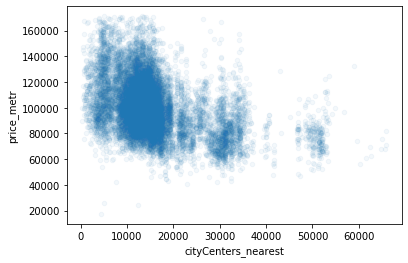

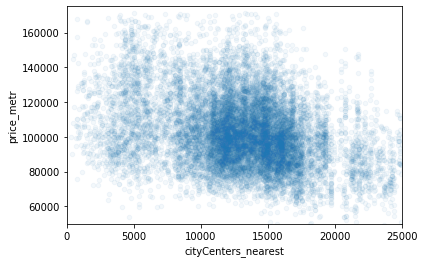

In [23]:
print("-----Распределение цены за кв.м, в зависимости от удаленности от центра -----")
clear_data.plot(x='cityCenters_nearest', y='price_metr',  kind='scatter', alpha=0.05)
clear_data.plot(x='cityCenters_nearest', y='price_metr',  kind='scatter', xlim=(0,25000), ylim=(50000,175000), alpha=0.05)
plt.show()

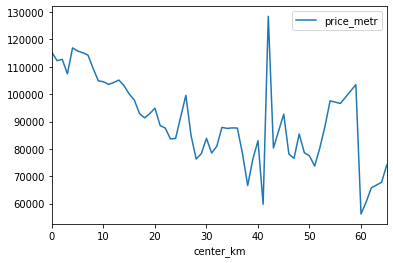

Корреляция  цены за кв.м и удаленности от центра: -0.40068611218067973


In [24]:
#изучаем зависимость цены от удаленности от центра. Взяли за метрику среднее.
clear_data.groupby('center_km')['price_metr'].mean().plot(legend=True)
plt.show()
print("Корреляция  цены за кв.м и удаленности от центра:",clear_data['center_km'].corr(clear_data['price_metr']))

-----Распределение цены за кв.м, в зависимости от количества комнат -----


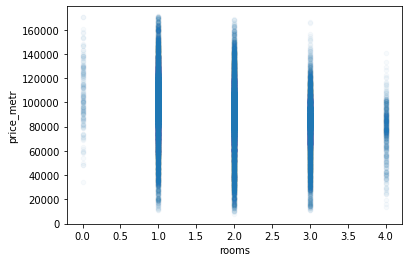

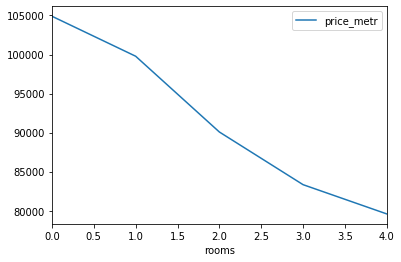

Корреляция цены за кв.м и количества комнат: -0.25630058092981556


In [25]:
#изучаем зависимость цены от числа комнат. Взяли за метрику медиану.
print("-----Распределение цены за кв.м, в зависимости от количества комнат -----")
clear_data.plot(x='rooms', y='price_metr', kind='scatter', alpha=0.03)
plt.show()
clear_data.groupby('rooms')['price_metr'].median().plot(legend=True)
plt.show()
print("Корреляция цены за кв.м и количества комнат:",clear_data['rooms'].corr(clear_data['price_metr']))

-----Распределение цены за кв.м, в зависимости от доли жилой площади -----


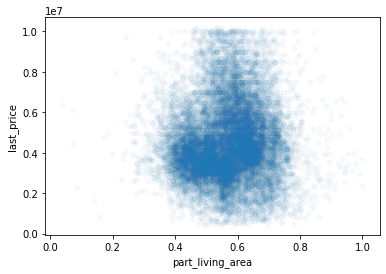

Корреляция цены и доли жилой площади: 0.035991299923939485


In [26]:
#изучаем зависимость цены от доли жилой площади
print("-----Распределение цены за кв.м, в зависимости от доли жилой площади -----")
clear_data.plot(x='part_living_area', y="last_price", kind='scatter', alpha=0.03)
plt.show()
print("Корреляция цены и доли жилой площади:",clear_data["last_price"].corr(clear_data['part_living_area']))

-----Распределение цены за кв.м, в зависимости от доли площади кухни -----


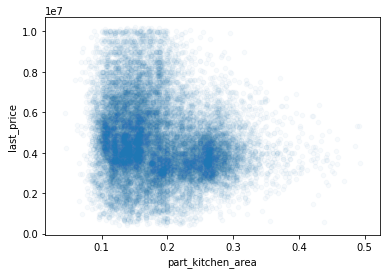

Корреляция цены и доли площади кухни: -0.1834401618723227


In [27]:
#изучаем зависимость цены от доли площади кухни
print("-----Распределение цены за кв.м, в зависимости от доли площади кухни -----")
clear_data.plot(x="part_kitchen_area", y="last_price", kind='scatter', alpha=0.03)
plt.show()
print("Корреляция цены и доли площади кухни:",clear_data["last_price"].corr(clear_data["part_kitchen_area"]))

-----Распределение цены за кв.м, в зависимости от дня недели подачи объявления -----


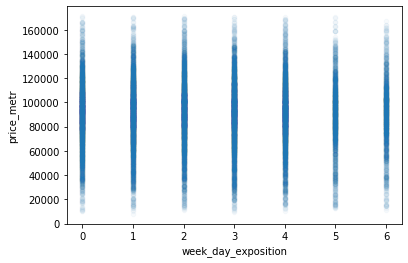

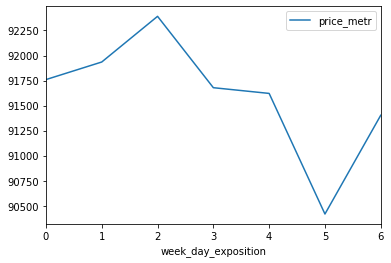

-----Распределение цены за кв.м, в зависимости от месяца подачи объявления -----


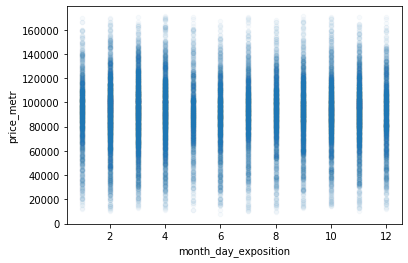

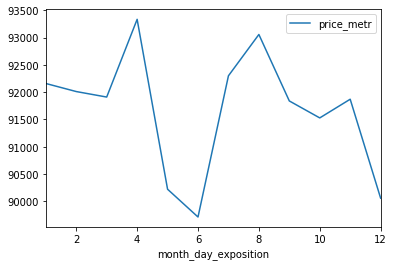

-----Распределение цены за кв.м, в зависимости от года подачи объявления -----


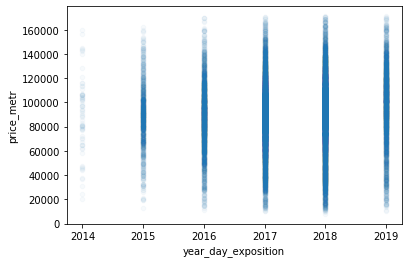

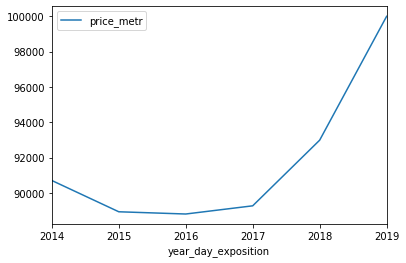

In [28]:
#изучаем зависимость цены от от дня недели, месяца, года. Взяли за метрику медиану.
print("-----Распределение цены за кв.м, в зависимости от дня недели подачи объявления -----")
clear_data.plot(x='week_day_exposition', y='price_metr', kind='scatter', alpha=0.03)
plt.show()
clear_data.groupby('week_day_exposition')['price_metr'].median().plot(legend=True)
plt.show()
print("-----Распределение цены за кв.м, в зависимости от месяца подачи объявления -----")
clear_data.plot(x='month_day_exposition', y='price_metr', kind='scatter', alpha=0.03)
plt.show()
clear_data.groupby('month_day_exposition')['price_metr'].median().plot(legend=True)
plt.show()
print("-----Распределение цены за кв.м, в зависимости от года подачи объявления -----")
clear_data.plot(x='year_day_exposition', y='price_metr', kind='scatter', alpha=0.03)
plt.show()
clear_data.groupby('year_day_exposition')['price_metr'].median().plot(legend=True)
plt.show()

In [29]:
#изучаем зависимость цены от расположения на этаже: первый, последний и другой.
print("-----Распределение цены за кв.м, в зависимости от категории этажа -----")
print(clear_data.groupby('floor_category')['price_metr'].median())
print()

-----Распределение цены за кв.м, в зависимости от категории этажа -----
floor_category
другой       95191.344227
первый       80000.000000
последний    83000.000000
Name: price_metr, dtype: float64



Для определения зависимости цены квадратного метра от **удаленности от центра** удобно построить график с параметрами *scatter* и коэффициентом прозрачности. На графике неплохо видно, что цена падает. Причем, явно выделяется 25-километровая зона - очевидно, это черта города, поэтому имеет смысл построить на эту часть графика отдельно. На первый взгляд кажется,  что в зоне 10км от центра цена практически не зависит от удаленности и только за пределами 10-километровой зоны цена квадратного метра начинает убывать по мере удаления от центра. 

Однако, график типа *scatter* не дает возможности визуально оценить поведение цен. Но мы можем для каждой группы квартир, удаленных от центра на 1,2,3 и т.д. км. посчитать медиану цена квадратного метра. Это должно быть довольно информативной характеристикой, т.к. медиана отображает именно ту цену, которая находится "в середине статистики". Ровно половина цен будет выше медианы и половина меньше, т.е. можно считать, что половина продавцов и покупателей готовы продавать квартиру за большую цену и половина - за меньшую. 

Построив такой график медианных цен становится хорошо видно, что цена за кв.м. непрерывно падает при удалении от центра, что закономено. При этом можно получить и количественные характеристики: в центре кв.метр жилья стоит 120т.р., а за 25км от центра цена составляет уже 85т.р.

Аналогично, рассмотрев зависимость цены к.в.метра от **количества комнат** в квартире видим, что график *scatter* дает нам общее представление о разбросе цен, но не является информативным в количественном выражении. График медианных цен напротив, дает количественные оценки и можно сказать, что медианная стоимость кв. метра в "однушке" - 100т.р., а в "трешке" падает до 84т.р. Этот факт довольно известный - цена квадратного метра в небольших квартирах всегда выше и наше исследование лишь подтверждает его. 

Зато можно сказать, что стоимость кв. метра почти не зависит **от доли жилой площади** или **доли кухни** в общей площади квартиры.

Довольно странно обстоят дела с зависимостью стоимости метра от **дня недели** подачи объявления. Данная зависимость явно просматривается, хотя она и не такая большая. Видимо, здесь играют роль какие-то особенности психологического настроя продавца.

Зависимость цены от **месяца** доволно закономерна - наблюдается явный провал на рынке в летние месяцы (май - июль) и всплески в апреле и августе. Очевидно, всплески есть из-за того, что люди стараются продать/купить квартиру до летних отпусков или сразу после. В декабре тоже виден спад, т.к. многие заняты подготовкой к праздникам.

**Статистика по годам** продажи показывает, что на рынке недвижимости был застой в 2015-2017 годах, после чего наблюдается рост нец на недвижимость. Средняя цена кв.метра выросла за два года с 90 до 100т.р.

Для анализа зависимости цены от **категории этажа** (первый, последний, другой) достаточно просто посчитать медианные цены квадратного метра для каждой из категорий этажа. Из них хорошо видно, что квартиры на первых и последних этажах стоят значительно дешевле "других", причем первый этаж ценится менее чем последний.

**Вывод:** наибольшее влияние на стоимость квартиры оказывает ее этаж и удаленность от центра. Также, заметна зависимость стоимости от числа комнат.

**Исследуем 10 населенных пунктов с наибольшим числом объявлений**

In [30]:
#исследуем 10 населенных пунктов с наибольшим числом объявлений
top_10_locality_name = (clear_data
                           .groupby('locality_name')['locality_name']
                           .count()
                           .sort_values(ascending=False)
                           .head(10)
)
price_mean_top_locality_name = []
for city_name in top_10_locality_name.index:
    price_mean_top_locality_name.append(clear_data[clear_data["locality_name"]==city_name]['price_metr'].mean())
price_mean_top = pd.DataFrame(data = [top_10_locality_name.index,price_mean_top_locality_name]).T
price_mean_top.set_axis(['locality_name_top',"price_metr_mean_top"], axis='columns',inplace=True)
print(price_mean_top.sort_values(by="price_metr_mean_top"))

   locality_name_top price_metr_mean_top
9             выборг             57947.2
3         всеволожск               66605
7            гатчина             68648.5
4            колпино             75268.1
2     посёлок шушары               78528
1     посёлок мурино             85826.1
6  посёлок парголово             90857.5
8    деревня кудрово             92921.4
5             пушкин             99875.9
0    санкт-петербург              103752


Очевидно, что в топ-10 городов по количеству объявлений входит Санкт-Петербург. Также ожидаемо, что средняя цена кв.м. наиболее высокая именно в Санкт-Петербурге. Самая низкая цена в Выборге, причем стоимость отличается почти в два раза.

**Выделим зону в Санкт-Петербурге, которую можно считать центром города**

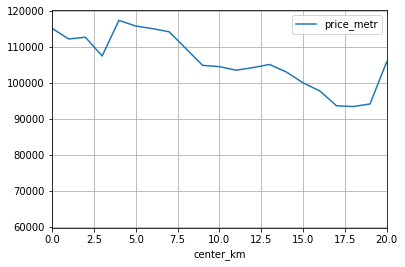

In [31]:
#Выберем все квартиы в СПб и уберем те, которые слишком далеко от центра
piter_data = clear_data[clear_data['locality_name'] == 'санкт-петербург']
q3_cityCenters_nearest = piter_data['cityCenters_nearest'].quantile(0.75)
piter_data = piter_data[piter_data['price_metr'] > q3_cityCenters_nearest* 1.5]

#выясняем какая часть входит в центр Санкт_Петербурга
piter_data.groupby('center_km')['price_metr'].mean().plot(grid=True,xlim=(0,20),legend=True)
plt.show()

На графике зависимости цены от удаления от центра хоро видны две аномалии: на расстоянии 2.5 и 7.5км от центра. Центр города не может быть ограничен радиусом 2.5км - это слишком мало. Возможно, данная аномалия обусловлена какими-то специфическими для города условиями расположения жилого фонда в центре. А вот радиус 7-8 км вполне похож на реальное значение, характеризующее центр города. 

Вывод - центром города в Санкт-Петербурге считается 8-километровая зона.

### Исследование квартир в центре города. 
Для этого построим те же самые графики, как и в начале, но на другом наборе данных:

-----Общая площадь в центре Питера-----


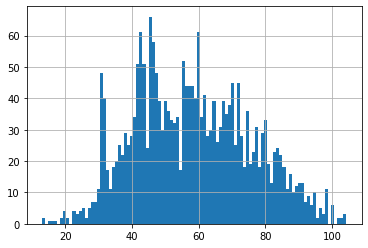

In [32]:
#анализируем сегмент квартир в центре
piter_data_center = piter_data.query('center_km <= 8')
print("-----Общая площадь в центре Питера-----")
piter_data_center["total_area"].hist(bins = 100)
plt.show()

-----Цена в центре Питера-----


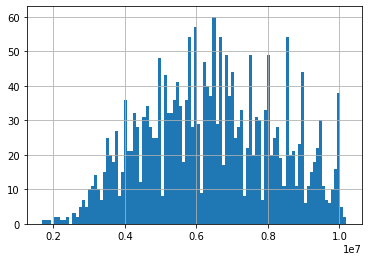

In [33]:
print("-----Цена в центре Питера-----")
piter_data_center["last_price"].hist(bins = 100)
plt.show()

-----Цена за кв.м в центре Питера-----


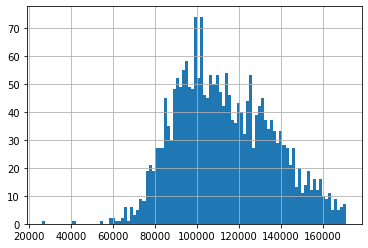

In [34]:
print("-----Цена за кв.м в центре Питера-----")
piter_data_center["price_metr"].hist(bins = 100)
plt.show()

-----Количество комнат в центре Питера-----


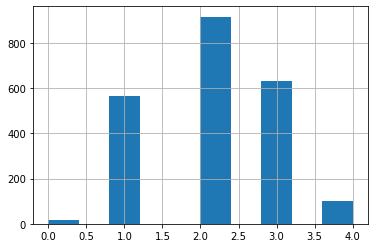

In [35]:
print("-----Количество комнат в центре Питера-----")
piter_data_center["rooms"].hist()
plt.show()

-----Высота потолков в центре Питера-----


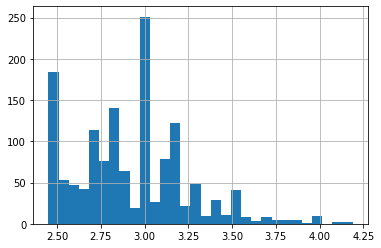

floor_category
другой       114285.714286
первый       101468.805704
последний    105956.322927
Name: price_metr, dtype: float64


In [36]:
print("-----Высота потолков в центре Питера-----")
piter_data_center["ceiling_height"].hist(bins = 30)
plt.show()
print(piter_data_center.groupby('floor_category')['price_metr'].median())

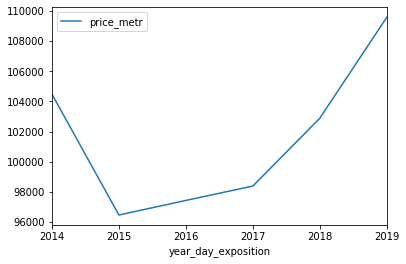

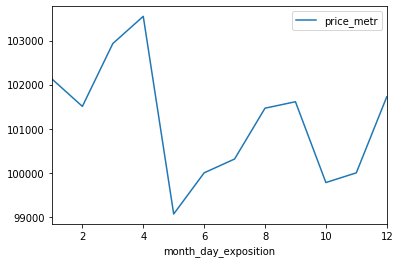

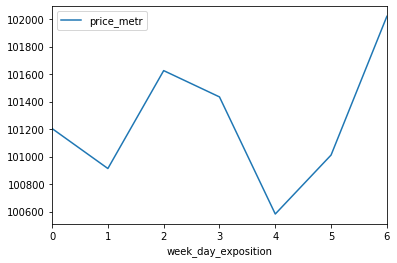

In [37]:
piter_data.groupby('year_day_exposition')['price_metr'].median().plot(legend=True)
plt.show()
piter_data.groupby('month_day_exposition')['price_metr'].median().plot(legend=True)
plt.show()
piter_data.groupby('week_day_exposition')['price_metr'].median().plot(legend=True)
plt.show()

Сравним данные по центру города с общими выводами, полученными ранее.
1. Гистограмма общей площади квартир в центре отличается от общей. В общей гистограмме явно преобладали 1-комнатные квартиры полощадью 45кв.м. и менее. В центре тоже есть такие квартиры но доля квартир большей площади явно выше.
2. Распределение стоимости квартир также подчинатеся нормальному закону распределения. Здесь нет никаких отличий за исключением того, что цена на недвижимость в центре выше, чем в общем по городу и области.
3. На гистограмме количества комнат явное отличие. Доля 1-комнатных квартир уменьшилась, а 3-комнатных увеличилась. Можем сделать вывод, что в центре преобладают с явным отрывом 2-комнатные квартиры, затем 3- и 1-комнатные, причем 3-комнатных больше.
4. Высота потолков также значиельно отличается. В целом по городу преобладают потолки высотой 2.5-2.7 метра ("хрущевки"), а в центре явно преобладают потолки высотой 3м - "сталинские" дома. 
5. Категория этажа по-прежнему значительно влияет на стоимость, причем так же, как и в целом по городу. 
6. Зависимости заты начала продажи и цены очень похожи на общие. Заметно лишь, что цена на недвижимость в центре города начала расти уже в 2017 году, тогда как в целом по городу рост наблюдается лишь с 2018 года.

### 5. Общий вывод

Проанализировав зависимость цены квадратного метра квартиры от различных факторов на примере базы данных объявлений в Санкт-Петербурге и пригороде можно сделать следующие выводы:
1. Стоимость квартиры **зависит** от различных факторов
2. Наибольше влияние на стоимость квадратного метра недвижимости оказывают **удаленность от центра**, **количество комнат**, **этаж**.
3. На стоимость квартиры незначительно влияет день недели и заметно влияет месяц размещения - цена падает летом и в декабре. И, конечно, цена зависела от года подачи объявления, т.к. цены на недвижимость меняются от года к году. 
4. В центре города квартиры в среднем дороже, но на их стоимость оказывают влияние те же факторы, что и на остальные, в первую очередь **количество комнат** и **этаж**.